In [12]:
# Copyright (C) 2025 Intel Corporation
# SPDX-License-Identifier: Apache-2.0

# DINOv3 Zero-Shot Classification Example

This notebook demonstrates how to use DINOv3 for zero-shot classification on ImageNet data.

## Overview
- Load ImageNet dataset with subset directories
- Initialize DinoTxt pipeline for zero-shot classification
- Learn from text prompts (class names)
- Perform inference on target images
- Calculate classification accuracy


## Setup and Imports

In [13]:
import timeit
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from getiprompt.pipelines.dinotxt import DinoTxtZeroShotClassification
from getiprompt.types import Priors, Image
from getiprompt.utils.constants import DINOv3BackboneSize

## Configuration

Set your parameters here:


In [14]:
# Configuration parameters
data_root = "caltech101"  # Update this path
precision = "bf16"  # Options: "bf16", "fp16", "fp32"

## Load Dataset


In [15]:
# Import dataset
data_root_path = Path(data_root)
gt_labels = []
label_names = []
target_images = []
for path in data_root_path.rglob("*/*.jpg"):
    label_name = path.parent.name
    if label_name not in label_names:
        label_names.append(label_name)
    img = Image(image_path=path)
    target_images.append(img)
    gt_labels.append(label_names.index(label_name))

print(f"Dataset loaded with {len(label_names)} classes")
print(f"Total items: {len(target_images)}")
print(f"Example classes: {label_names}")

Dataset loaded with 5 classes
Total items: 25
Example classes: ['grand_piano', 'dolphin', 'butterfly', 'chair', 'airplanes']


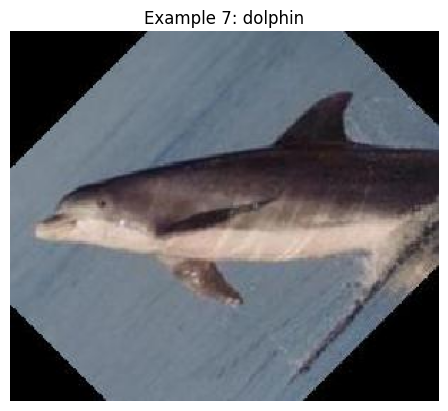

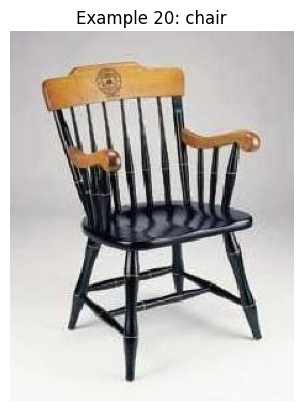

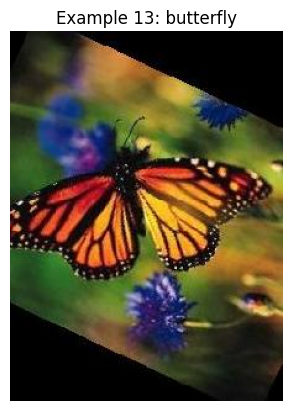

In [16]:
# Display a few random example images with matplotlib
random_indices = np.random.Generator(np.random.PCG64()).permutation(len(target_images))[:3]
for i in random_indices:
    img = target_images[i]
    label = label_names[gt_labels[i]]
    plt.imshow(img.data)
    plt.title(f"Example {i + 1}: {label}")
    plt.axis("off")
    plt.show()

## Prepare Target Images and Ground Truth Labels


## Initialize DinoTxt Pipeline


In [17]:
# Initialize DinoTxt pipeline
print("Initializing DinoTxt pipeline...")
dinotxt = DinoTxtZeroShotClassification(precision=precision, backbone_size=DINOv3BackboneSize.LARGE)
print("Pipeline initialized successfully!")

Initializing DinoTxt pipeline...


Using cache found in /home/daan/.cache/torch/hub/facebookresearch_dinov3_main


Pipeline initialized successfully!


## Learn from Text Prompts

In [18]:
# Learn from text prompts (class names)
print("Learning from text prompts...")
start_time = timeit.default_timer()

dinotxt.learn(
    reference_images=[],
    reference_priors=[Priors(text=dict(enumerate(label_names)))],
)

learn_time = timeit.default_timer() - start_time
print(f"Learning completed in {learn_time:.2f} seconds")

Learning from text prompts...
Learning completed in 0.62 seconds


## Perform Inference


In [19]:
# Perform inference on target images
print("Starting inference...")
inference_start_time = timeit.default_timer()

results = dinotxt.infer(target_images=target_images)
pred_labels = [mask.class_ids()[0] for mask in results.masks]

# Convert to tensors
pred_labels = torch.stack(pred_labels).cuda()
gt_labels = torch.tensor(gt_labels).cuda()

inference_time = timeit.default_timer() - inference_start_time
print(f"Inference completed in {inference_time:.2f} seconds")

Starting inference...
Inference completed in 0.49 seconds


## Calculate Results


In [20]:
# Calculate zero-shot classification accuracy
accuracy = sum(pred_labels == gt_labels) / len(gt_labels)
total_time = timeit.default_timer() - start_time

print("=" * 50)
print("RESULTS")
print("=" * 50)
print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")
print(f"Total time: {total_time:.2f} seconds")
print(f"Time per image: {total_time / len(target_images):.4f} seconds")
print(f"Images processed: {len(target_images)}")
print(f"Precision: {precision}")
print("=" * 50)

RESULTS
Accuracy: 0.2000 (20.00%)
Total time: 1.13 seconds
Time per image: 0.0451 seconds
Images processed: 25
Precision: bf16
